In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-

# https://arxiv.org/pdf/2006.11239.pdf

import torch
from torch import optim, nn

from tqdm import tqdm
from random import randint

from load_dataset import load_dataset, plot_image, load_contour
from UNet import UNet
from torchvision.transforms import v2
from matplotlib import pyplot as plt

device = "cuda"

pimages = load_dataset().to(device)
pimages.shape

#contour = load_contour().to(device)
#contour.shape

torch.Size([3, 386, 3, 64, 64])

In [2]:
T = 500
beta = torch.linspace(10e-3, 0.01, T, device=device)

alpha = 1 - beta

alpha_ = torch.zeros(T, device=device)

for i in range(T):
    alpha_[i] = torch.prod(alpha[0:i+1])

alpha_[-1]

tensor(0.0066, device='cuda:0')

In [3]:
alpha_

tensor([0.9900, 0.9801, 0.9703, 0.9606, 0.9510, 0.9415, 0.9321, 0.9227, 0.9135,
        0.9044, 0.8953, 0.8864, 0.8775, 0.8687, 0.8601, 0.8515, 0.8429, 0.8345,
        0.8262, 0.8179, 0.8097, 0.8016, 0.7936, 0.7857, 0.7778, 0.7700, 0.7623,
        0.7547, 0.7472, 0.7397, 0.7323, 0.7250, 0.7177, 0.7106, 0.7034, 0.6964,
        0.6894, 0.6826, 0.6757, 0.6690, 0.6623, 0.6557, 0.6491, 0.6426, 0.6362,
        0.6298, 0.6235, 0.6173, 0.6111, 0.6050, 0.5990, 0.5930, 0.5870, 0.5812,
        0.5754, 0.5696, 0.5639, 0.5583, 0.5527, 0.5472, 0.5417, 0.5363, 0.5309,
        0.5256, 0.5203, 0.5151, 0.5100, 0.5049, 0.4998, 0.4948, 0.4899, 0.4850,
        0.4801, 0.4753, 0.4706, 0.4659, 0.4612, 0.4566, 0.4520, 0.4475, 0.4430,
        0.4386, 0.4342, 0.4299, 0.4256, 0.4213, 0.4171, 0.4130, 0.4088, 0.4047,
        0.4007, 0.3967, 0.3927, 0.3888, 0.3849, 0.3810, 0.3772, 0.3735, 0.3697,
        0.3660, 0.3624, 0.3587, 0.3552, 0.3516, 0.3481, 0.3446, 0.3412, 0.3378,
        0.3344, 0.3310, 0.3277, 0.3244, 

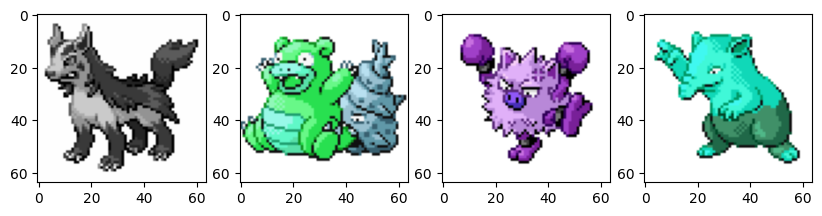

In [4]:
transform = v2.Compose([
    v2.ColorJitter(),
    v2.RandomChannelPermutation(),
    v2.RandomGrayscale(p = 0.1),
    #v2.GaussianBlur(kernel_size=9, sigma=(1,1))
])

source = randint(0, 2)
batch = torch.randperm(385)[:4]
x0 = pimages[source, batch]
x0 = torch.stack([transform(x) for x in x0], dim=0)

fig, axes = plt.subplots(1, 4, figsize=(10, 10))
plot_image(x0[0], axes[0])
plot_image(x0[1], axes[1])
plot_image(x0[2], axes[2])
plot_image(x0[3], axes[3])
plt.show()

In [5]:
pimages.min(), pimages.max()

(tensor(0., device='cuda:0'), tensor(1., device='cuda:0'))

In [6]:
def isigmoid(x):
    eps = 0.1
    return torch.log(x + eps) - torch.log(1 - x + eps)


In [7]:
model = UNet(3, 3).to(device)

@torch.no_grad
def generate_image():
    model.eval()

    #cont = contour[1, 151]
    x = torch.randn((3,64,64), device=device)

    for t in reversed(range(T)):
        tt = torch.tensor(t, device=device)

        z = torch.randn((3,64,64), device=device)

        #xn = torch.cat([x, cont], dim=0)
        e = model(x[None], tt)[0] * (1 - alpha[t]) / torch.sqrt(1 - alpha_[t])

        x = (1 / torch.sqrt(alpha[t])) * (x - e) + z * torch.sqrt(beta[t])
        
    plot_image(torch.sigmoid(x))
    plt.show()

    model.train()

  0%|          | 0/100001 [00:00<?, ?it/s]

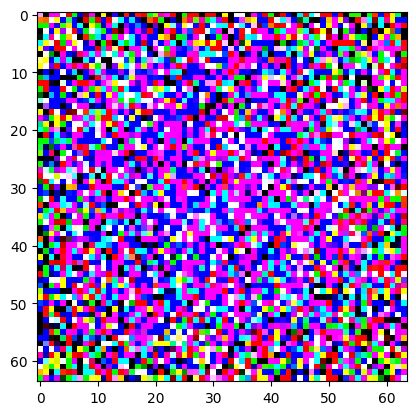

0.08733230:   1%|          | 999/100001 [01:20<2:07:29, 12.94it/s]

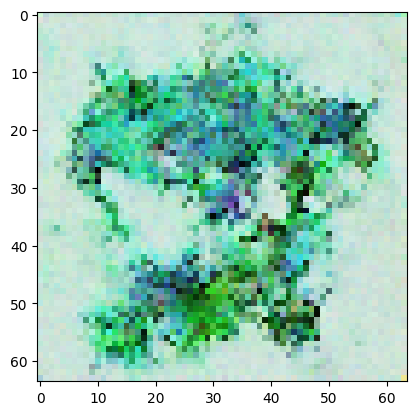

0.05572909:   2%|▏         | 1999/100001 [02:40<2:06:27, 12.92it/s] 

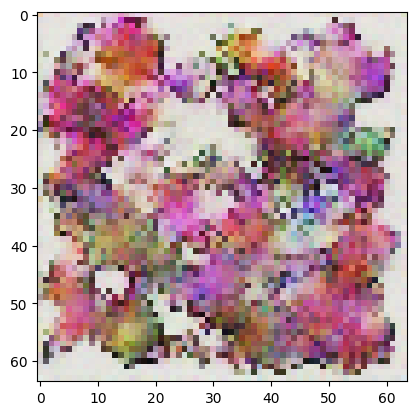

0.03348893:   3%|▎         | 2999/100001 [04:01<2:05:15, 12.91it/s] 

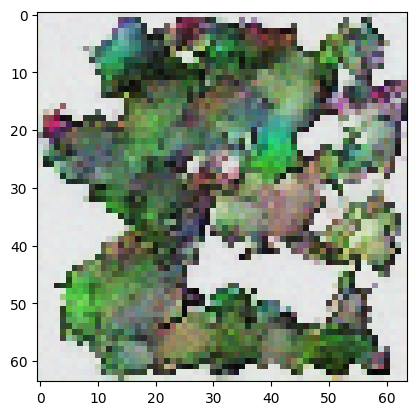

0.04832218:   4%|▍         | 3999/100001 [05:21<2:03:44, 12.93it/s] 

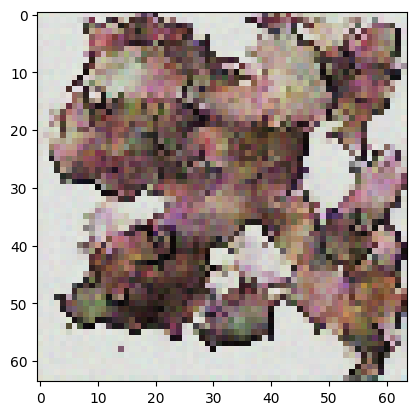

0.02079683:   5%|▍         | 4999/100001 [06:42<2:03:20, 12.84it/s] 

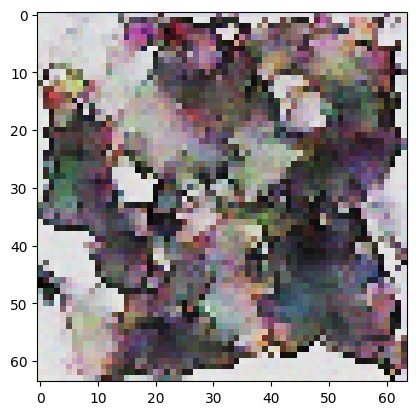

0.04289676:   6%|▌         | 5999/100001 [08:02<2:01:29, 12.90it/s] 

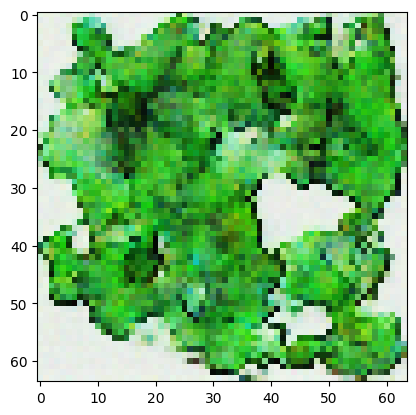

0.02981837:   7%|▋         | 6999/100001 [09:22<2:00:34, 12.85it/s] 

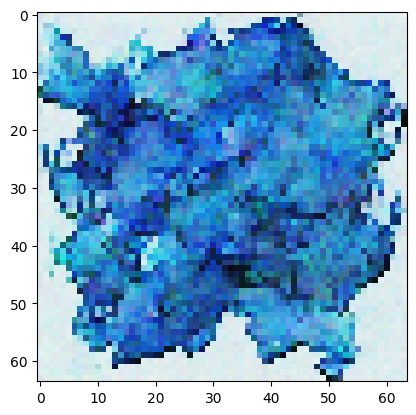

0.06710468:   8%|▊         | 7999/100001 [10:43<1:58:40, 12.92it/s] 

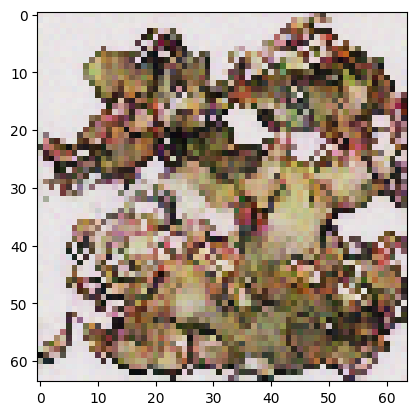

0.04128993:   9%|▉         | 8999/100001 [12:03<1:57:28, 12.91it/s] 

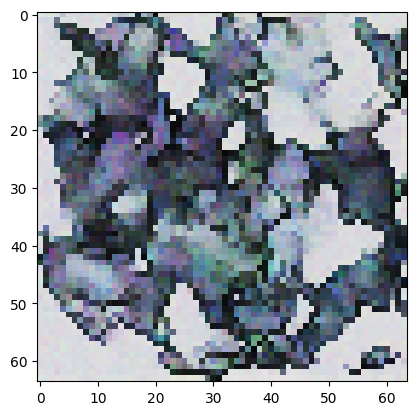

0.04502114:  10%|▉         | 9999/100001 [13:24<1:55:54, 12.94it/s] 

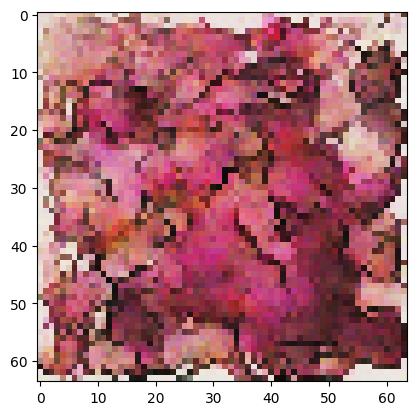

0.03701669:  11%|█         | 10999/100001 [14:44<1:55:03, 12.89it/s] 

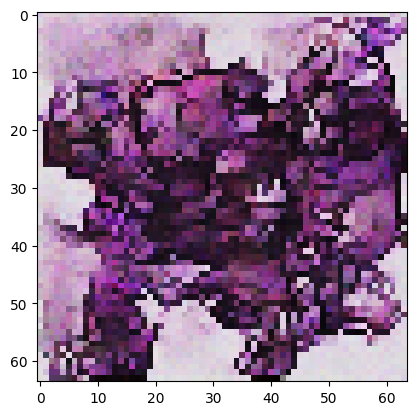

0.02758860:  12%|█▏        | 11999/100001 [16:05<1:53:33, 12.92it/s] 

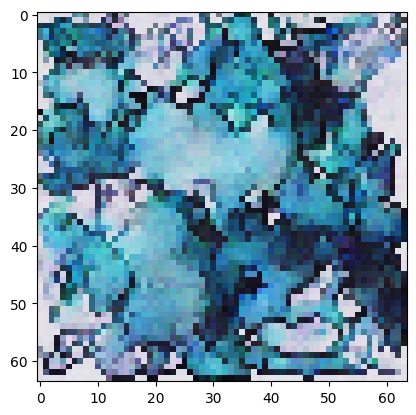

0.05641021:  13%|█▎        | 12999/100001 [17:25<1:50:48, 13.09it/s] 

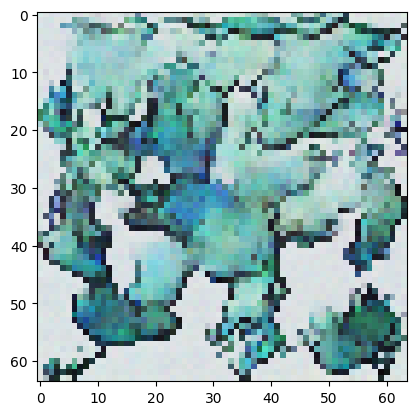

0.03713784:  14%|█▍        | 13999/100001 [18:45<1:50:11, 13.01it/s] 

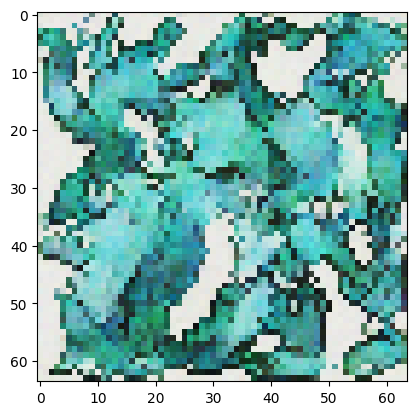

0.05477340:  15%|█▍        | 14999/100001 [20:08<1:49:49, 12.90it/s] 

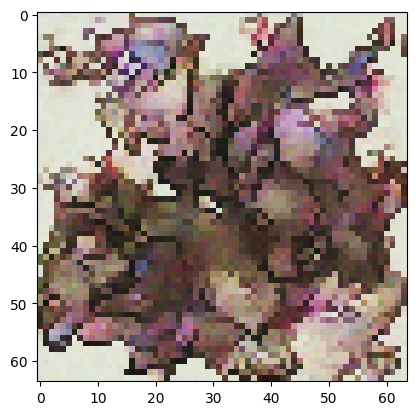

0.02991754:  16%|█▌        | 15999/100001 [21:29<1:48:34, 12.90it/s] 

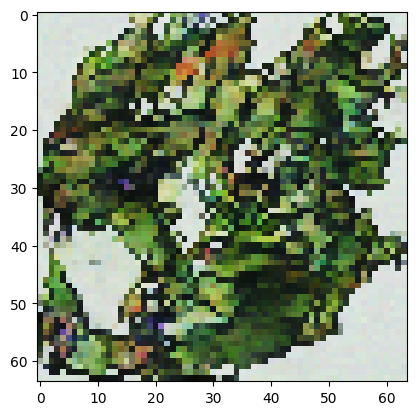

0.02045932:  17%|█▋        | 16999/100001 [22:49<1:47:18, 12.89it/s] 

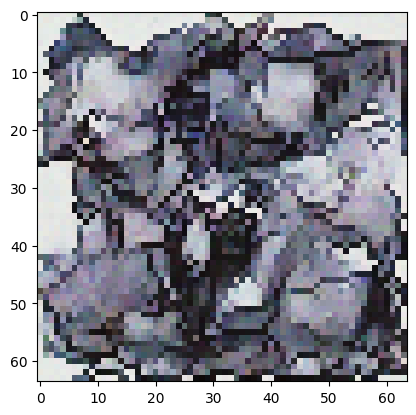

0.03232254:  18%|█▊        | 18000/100001 [24:13<1:45:41, 12.93it/s] 

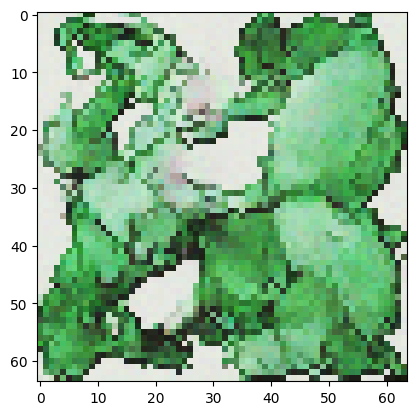

0.02529925:  19%|█▉        | 19000/100001 [25:34<1:44:45, 12.89it/s] 

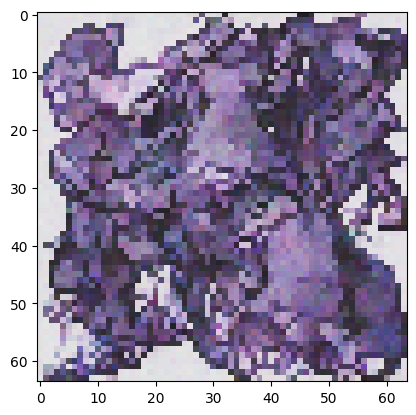

0.02874224:  20%|█▉        | 20000/100001 [26:58<1:43:21, 12.90it/s] 

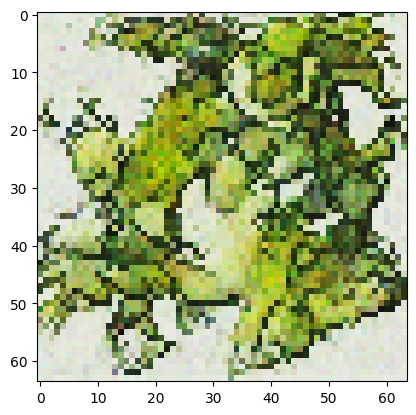

0.02216753:  21%|██        | 21000/100001 [28:18<1:40:36, 13.09it/s] 

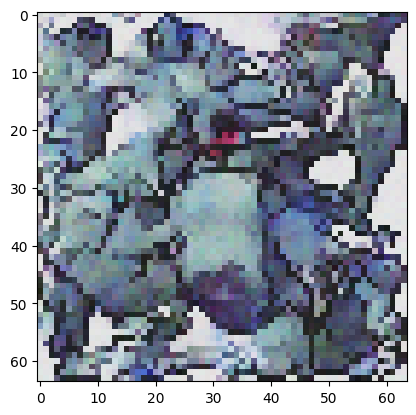

0.02233087:  22%|██▏       | 22000/100001 [29:42<1:40:42, 12.91it/s] 

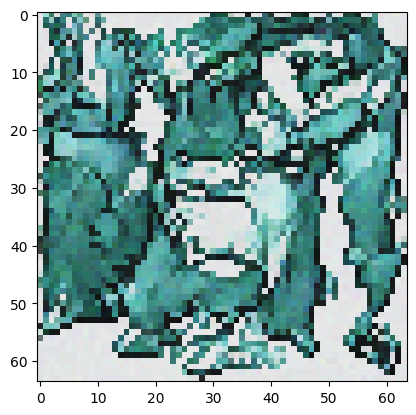

0.03113456:  23%|██▎       | 23000/100001 [31:02<1:38:06, 13.08it/s] 

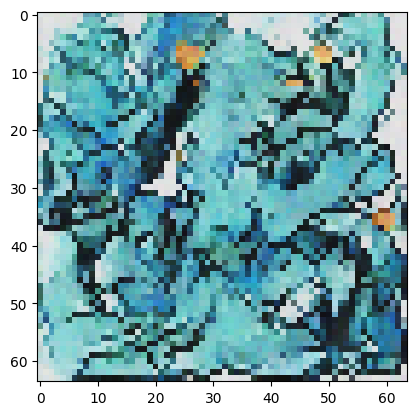

0.02832856:  24%|██▍       | 24000/100001 [32:21<1:36:47, 13.09it/s] 

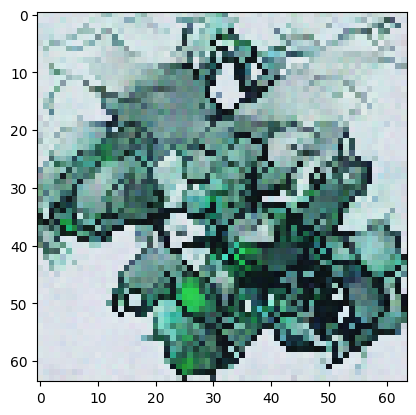

0.02548765:  25%|██▍       | 25000/100001 [33:40<1:35:52, 13.04it/s] 

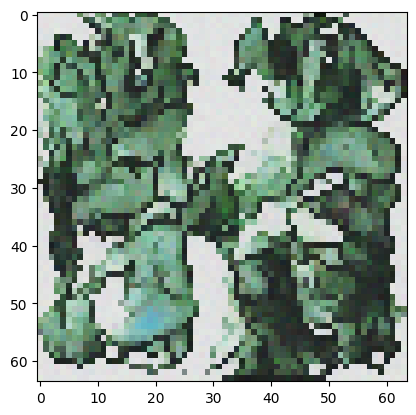

0.03847156:  26%|██▌       | 25999/100001 [35:04<1:37:25, 12.66it/s] 

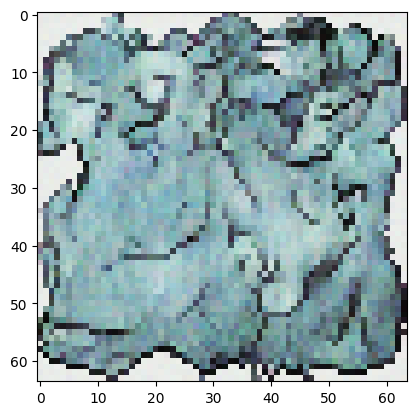

0.03723718:  27%|██▋       | 26999/100001 [36:23<1:32:58, 13.09it/s] 

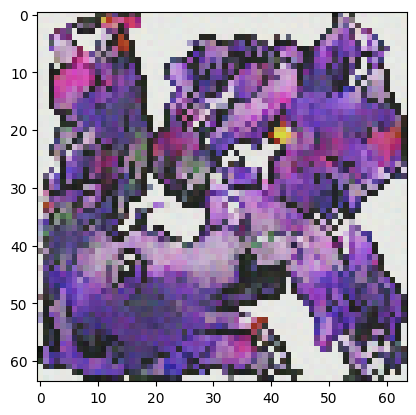

0.04900370:  28%|██▊       | 27999/100001 [37:43<1:31:40, 13.09it/s] 

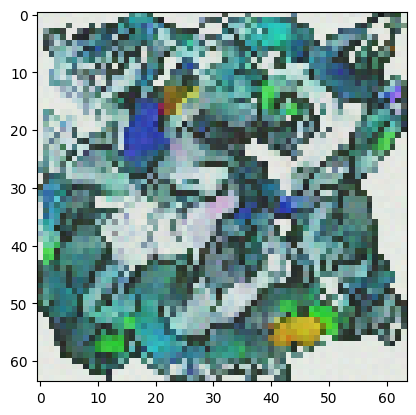

0.02992259:  29%|██▉       | 28999/100001 [39:04<1:30:15, 13.11it/s] 

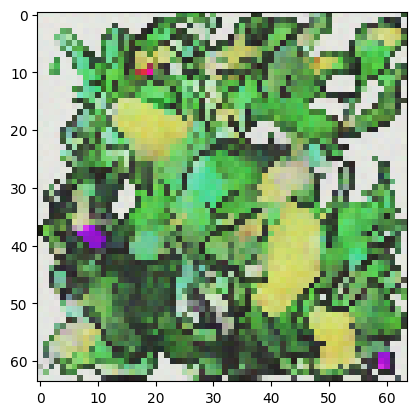

0.03969204:  30%|██▉       | 29999/100001 [40:23<1:29:46, 13.00it/s] 

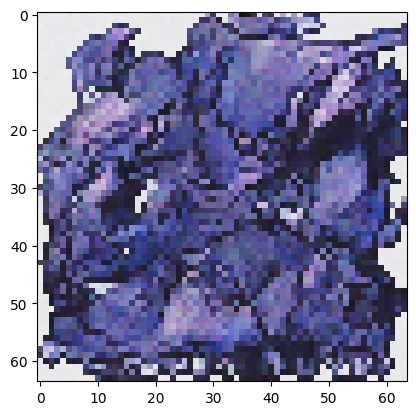

0.04326902:  31%|███       | 30999/100001 [41:43<1:28:11, 13.04it/s]

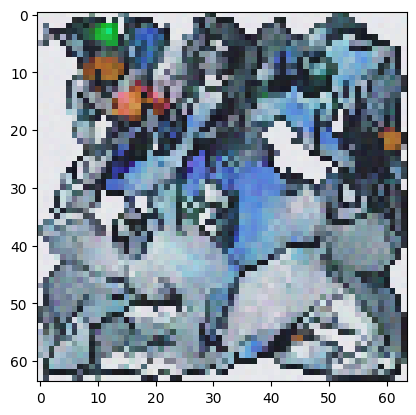

0.01837548:  32%|███▏      | 31999/100001 [43:03<1:26:55, 13.04it/s]

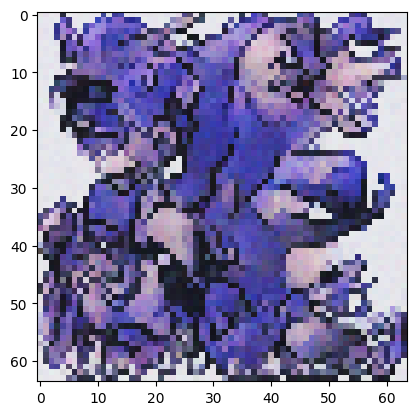

0.02952304:  33%|███▎      | 32999/100001 [44:23<1:25:38, 13.04it/s]

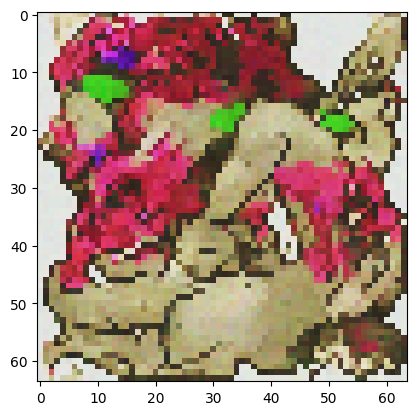

0.02581299:  34%|███▍      | 33999/100001 [45:42<1:25:17, 12.90it/s]

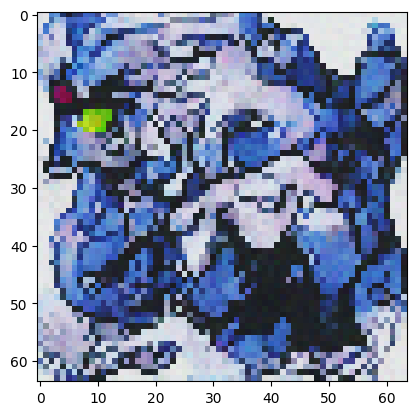

0.02683255:  35%|███▍      | 34999/100001 [47:02<1:22:55, 13.06it/s]

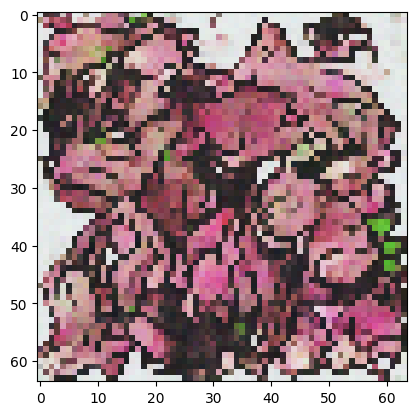

0.02197142:  36%|███▌      | 35999/100001 [48:21<1:21:42, 13.06it/s]

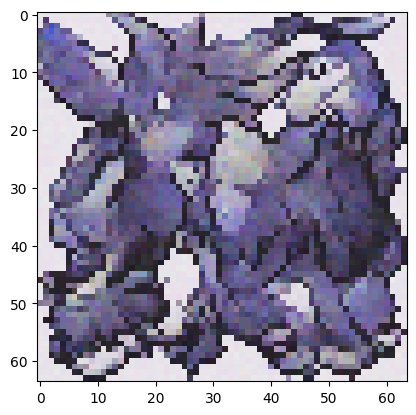

0.04363443:  37%|███▋      | 36999/100001 [49:41<1:20:34, 13.03it/s]

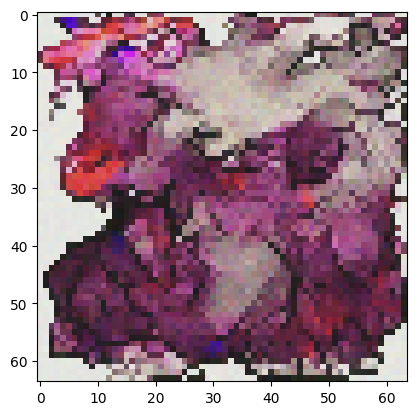

0.03387326:  38%|███▊      | 37999/100001 [51:01<1:19:15, 13.04it/s]

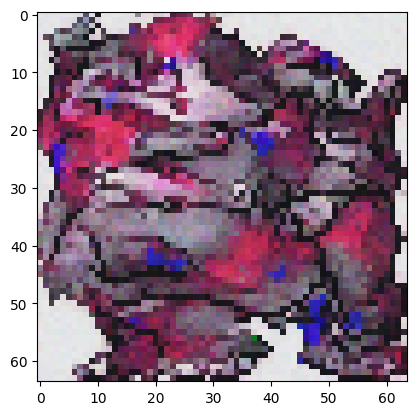

0.03072817:  38%|███▊      | 38021/100001 [51:06<1:23:18, 12.40it/s]


KeyboardInterrupt: 

In [8]:
loss_func = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)
    
pbar = tqdm(range(100001))#, miniters=15)
def closure():
    optimizer.zero_grad()

    bs = 8

    source = randint(0, 2)
    batch = torch.randperm(385)[:bs]
    x0 = pimages[source, batch]
    x0 = torch.stack([transform(x) for x in x0], dim=0)
    x0 = isigmoid(x0)
    
    e = torch.randn(x0.shape, device=device)
    t = torch.randint(0, T - 1, (bs,), device=device)

    x_nois = torch.sqrt(alpha_[t])[:, None, None, None] * x0 + torch.sqrt(1-alpha_[t])[:, None, None, None] * e
    #xc = contour[source, batch]
    #xn = torch.cat([x_nois, xc], dim=1)

    e_pred = model(x_nois, t)

    # Calculate the loss between the result and the noise
    loss = loss_func(e, e_pred)
    loss.backward()
    
    pbar.set_description(f"%.8f" % loss, refresh=False)
    
    return loss

model.train()
for j in pbar:
    optimizer.step(closure)

    if j % 1000 == 0:
        generate_image()

torch.save(model.state_dict(), 'model.pt')